# Utilisation de Unets pour le débruitage d'image :
L'Unet est une sorte d'autoencodeur mais avec des connections résiduelles entre l'encodeur et le décodeur afin d'éviter la disparition du gradient et de connecter les informations extraites par l'encodeur au décodeur plus facilement. Ces connections permettent au réseasu de capturer et de propager efficacement les informations de contexte.

![Unet architecture](https://raw.githubusercontent.com/Automatants/projets-de-permanence/master/image-hosting/TP4_Unet/u-net-architecture.png)


L'Unet est composée d'une structure encodeur-décodeur avec des connexions de saut (skip connections), lui permettant de capturer à la fois des features de haut et bas niveau.

L'architecture Unet en détail:

Encodeur : L'encodeur est responsable de l'extraction des features de l'image en entrée. Il consiste de plusieurs blocs de couche de convolution et un maxpooling entre chaque bloc pour réduire la taille de l'image.

Décodeur : Le décodeur s'occupe de la tâche essentielle de remapper les features de haut niveau extraites par l'encodeur en une image de sortie reconstruite. Il est composé également de plusieurs blocs, et utilise des couches de convolution transposées pour effectuer l'upsampling des features, rétablissant ainsi leurs dimensions originales. Chaque bloc du décodeur reçoit non seulement les données upsampled du bloc précédent, mais aussi les données de l'encodeur correspondant grâce aux connexions de saut. Ces données concaténées sont ensuite transmises à travers des couches de convolution pour affiner les features upsampled.


## Importation des librairies et téléchargements de MNIST

In [22]:
# Commande pour installer les dépendances requises
!source .venv/bin/activate
!pip install -q torch torchvision matplotlib numpy

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

X_train = train_dataset.data
X_test = test_dataset.data

print(X_train.shape)
print(X_test.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])



## Exercice 1: Normalisation des images et ajout de bruit
Normaliser les images en [0, 1] et ajouter du bruit sur les images de train et de test.

In [4]:
import torch
#Normaliser les images en [0, 1] et ajouter du bruit sur les images de train et de test.
X_train_normalized = X_train.float() / 255
X_test_normalized = X_test.float() / 255

#Ajouter du bruit gaussien sur les images
X_train_noise = X_train_normalized + 0.5 * torch.randn(X_train_normalized.size())
X_test_noise = X_test_normalized + 0.5 * torch.randn(X_test_normalized.size())

#Clipping des valeurs pour les ramener dans l'intervalle [0, 1]
X_train_noise = torch.clamp(X_train_noise, 0, 1)
X_test_noise = torch.clamp(X_test_noise, 0, 1)


## Exercice 2: Visualisation des données bruitées

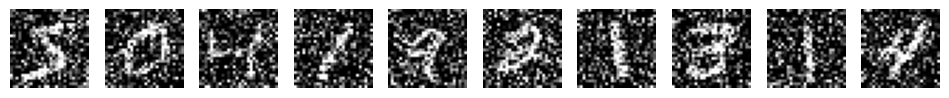

In [5]:
#Visualisation des images bruitées X_train_noise
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    axes[i].imshow(X_train_noise[i], cmap='gray')
    axes[i].axis('off')
plt.show()




## Exercice 3: Création du modèle


### Encodeur
Voici le schéma de l'encodeur qu'on va créer (avec des ReLU après chaque couche de convolution):


In [6]:
# Layer (type)                   Output Shape              
# ================================================================
# input_1               (1, 28, 28)
# ________________________________________________________________
# conv2d_1              (32, 28, 28)
# ________________________________________________________________
# maxpooling2d_1        (32, 14, 14)
# ________________________________________________________________
# conv2d_2              (64, 14, 14)
# ________________________________________________________________
# maxpooling2d_2        (64, 7, 7)
# ________________________________________________________________
# conv2d_3 (Conv2D)     (128, 7, 7)
# ________________________________________________________________
# maxpooling2d_3        (128, 3, 3)
# ________________________________________________________________
# conv2d_4              (256, 3, 3)
# ________________________________________________________________
# maxpooling2d_4        (256, 1, 1)
# ________________________________________________________________
# conv2d_5              (256, 1, 1)
# ________________________________________________________________
# outputs               [(32, 28, 28), (64, 14, 14), (128, 7, 7), (256, 3, 3), (256, 1, 1)]

Il faut retourner non seulement la sortie de conv2d_5 mais aussi les sorties de conv2d_1, conv2d_2, conv2d_3 et conv2d_4 pour les utiliser dans le décodeur.

### Décodeur

Voici le schéma du décodeur qu'on va créer (avec des ReLU après chaque couche de convolution):

In [7]:
# Layer (type)                   Output Shape
# ================================================================
# input_1               [(32, 28, 28), (64, 14, 14), (128, 7, 7), (256, 3, 3), (256, 1, 1)]
# ________________________________________________________________
# conv2d_transpose_1    (256, 3, 3)
# ________________________________________________________________
# concatenate_1         (512, 3, 3)
# ________________________________________________________________
# conv2d_6              (256, 3, 3)
# ________________________________________________________________
# conv2d_transpose_2    (128, 7, 7)
# ________________________________________________________________
# concatenate_2         (256, 7, 7)
# ________________________________________________________________
# conv2d_7              (128, 7, 7)
# ________________________________________________________________
# conv2d_transpose_3    (64, 14, 14)
# ________________________________________________________________
# concatenate_3         (128, 14, 14)
# ________________________________________________________________
# conv2d_8              (64, 14, 14)
# ________________________________________________________________
# conv2d_transpose_4    (32, 28, 28)
# ________________________________________________________________
# concatenate_4         (64, 28, 28)
# ________________________________________________________________
# conv2d_9              (1, 28, 28)
# ________________________________________________________________


In [8]:
import torch
import torch.nn as nn

#  si MPS est disponible
device = torch.device("mps" if torch.mps.is_available() else "cpu")

# Définir votre modèle UNet
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, activate=nn.ReLU)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, activate=nn.ReLU)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1, activate=nn.ReLU)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1, activate=nn.ReLU)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1, activate=nn.ReLU)
        self.pool = nn.MaxPool2d(2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(256, 256, kernel_size=3, stride=1, activate=nn.ReLU)
        self.conv6 = nn.Conv2d(512, 256, kernel_size=3, padding=1, activate=nn.ReLU)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, activate=nn.ReLU)
        self.conv7 = nn.Conv2d(256, 128, kernel_size=3, padding=1, activate=nn.ReLU)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, activate=nn.ReLU)
        self.conv8 = nn.Conv2d(128, 64, kernel_size=3, padding=1, activate=nn.ReLU)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, activate=nn.ReLU)
        self.conv9 = nn.Conv2d(64, 1, kernel_size=5, padding=2)

    def forward(self, x):
        # Encoder
        conv1_out = self.conv1(x)
        pool1 = self.pool(conv1_out)

        conv2_out = self.conv2(pool1)
        pool2 = self.pool(conv2_out)

        conv3_out = self.conv3(pool2)
        pool3 = self.pool(conv3_out)

        conv4_out = self.conv4(pool3)
        pool4 = self.pool(conv4_out)

        conv5_out = self.conv5(pool4)

        # Decoder
        upconv1 = self.upconv1(conv5_out)
        concat1 = torch.concatenate([upconv1, conv4_out], dim=1)
        conv6_out = self.conv6(concat1)

        upconv2 = self.upconv2(conv6_out)
        concat2 = torch.concatenate([upconv2, conv3_out], dim=1)
        conv7_out = self.conv7(concat2)

        upconv3 = self.upconv3(conv7_out)
        concat3 = torch.concatenate([upconv3, conv2_out], dim=1)
        conv8_out = self.conv8(concat3)

        upconv4 = self.upconv4(conv8_out)
        concat4 = torch.concatenate([upconv4, conv1_out], dim=1)
        conv9_out = self.conv9(concat4)

        return conv9_out



In [9]:
#Résumé du modèle
from torchsummary import summary

unettest = UNet()
batch_size = 5
summary(unettest, input_size=(1, 28, 28), batch_size=batch_size)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [5, 32, 28, 28]             320
         MaxPool2d-2            [5, 32, 14, 14]               0
            Conv2d-3            [5, 64, 14, 14]          18,496
         MaxPool2d-4              [5, 64, 7, 7]               0
            Conv2d-5             [5, 128, 7, 7]          73,856
         MaxPool2d-6             [5, 128, 3, 3]               0
            Conv2d-7             [5, 256, 3, 3]         295,168
         MaxPool2d-8             [5, 256, 1, 1]               0
            Conv2d-9             [5, 256, 1, 1]         590,080
  ConvTranspose2d-10             [5, 256, 3, 3]         590,080
           Conv2d-11             [5, 256, 3, 3]       1,179,904
  ConvTranspose2d-12             [5, 128, 7, 7]         295,040
           Conv2d-13             [5, 128, 7, 7]         295,040
  ConvTranspose2d-14            [5, 64,

## Entraînement du modèle et visualisation des résultats

/var/folders/js/h6rww9rj5jx455zd07xyz1340000gn/T/ipykernel_74316/2134534226.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load('unet.pth'))


Epoch 2/10, Loss: 0.01106
Epoch 3/10, Loss: 0.01097
Epoch 4/10, Loss: 0.01091
Epoch 5/10, Loss: 0.01086
Epoch 6/10, Loss: 0.01082
Epoch 7/10, Loss: 0.01078
Epoch 8/10, Loss: 0.01078
Epoch 9/10, Loss: 0.01074
Epoch 10/10, Loss: 0.01071


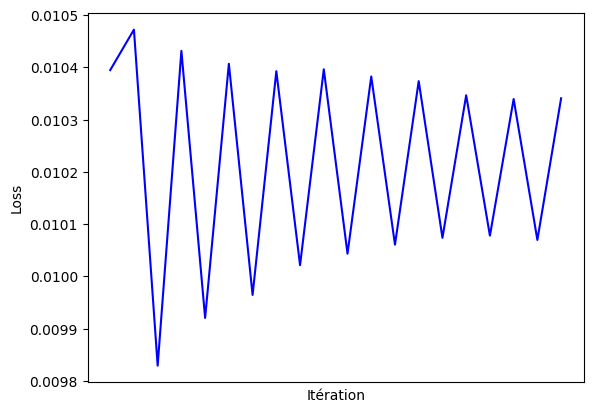

Finished Training
Loss: 0.0107


In [23]:
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Charger le modèle
unet = UNet().to(device)
unet.load_state_dict(torch.load('unet.pth'))
unet.eval()

# Définir la fonction de coût et l'optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0005)

# Initialiser une liste pour stocker les pertes
losses = []

# Configurer le graphe
fig, ax = plt.subplots()
ax.set_xlabel('Itération')
ax.set_ylabel('Loss')
line, = ax.plot(losses, color='blue')  # Initialiser la courbe
# Entraîner le modèle
n_epochs = 10
batch_size = 128
for epoch in range(n_epochs):
    if epoch > 0:
        print(f'Epoch {epoch}/{n_epochs}, Loss: {loss.item():.5f}')
    for i in range(0, len(X_train_noise), batch_size):
        # Transférer les entrées et les cibles sur l'appareil
        inputs = X_train_noise[i:i+batch_size].unsqueeze(1).to(device)
        targets = X_train_normalized[i:i+batch_size].unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = unet(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Ajouter la perte à la liste
        if i % 40960 == 0:  # Affiche le graphe à chaque 40960 itérations
            losses.append(loss.item())

# Fin de l'entraînement
line.set_ydata(losses)
line.set_xdata(range(len(losses)))  # Ajuster correctement l'axe X
ax.relim()  # Ajuster les limites du graphe
ax.autoscale_view()  # Redimensionner automatiquement

ax.set_xticks([])  # Effacer les ticks de l'axe X
plt.show()  # Afficher le dernier graphique

print('Finished Training')
print(f'Loss: {loss.item():.4f}')

# Sauvegarder le modèle
torch.save(unet.state_dict(), 'unet.pth')


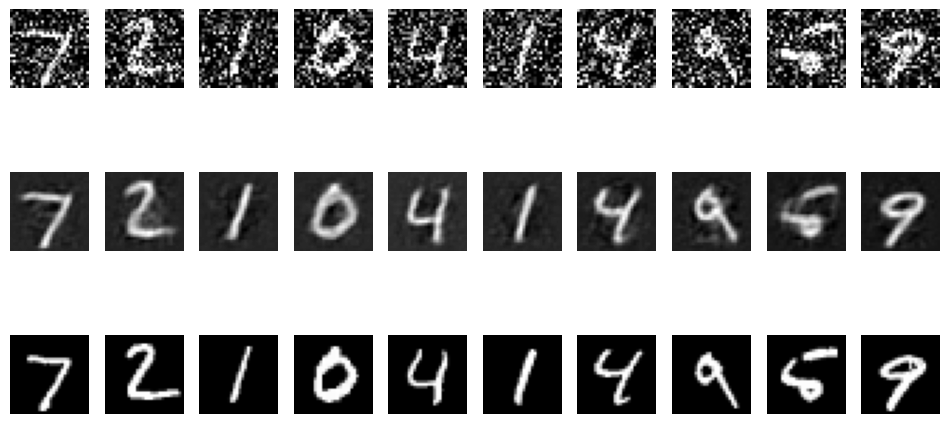

In [24]:
#VISUALISATION DES RÉSULTATS

import torch
import numpy as np
import matplotlib.pyplot as plt

# Déplacez le modèle sur le bon appareil
unet = unet.to(device)

# Nombre d'images à tester
n_images = 10

# Prépare la figure pour l'affichage
fig, axes = plt.subplots(3, n_images, figsize=(12, 6))

for i in range(n_images):
    # Déplacez les images bruitées vers le bon appareil
    image = X_test_noise[i].unsqueeze(0).unsqueeze(0).to(device)
    
    # Passe l'image à travers le modèle
    output = unet(image)
    
    # Déplacez l'image de sortie vers le CPU pour l'affichage
    axes[0, i].imshow(X_test_noise[i].cpu(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(output.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[2, i].imshow(X_test[i].cpu(), cmap='gray')
    axes[2, i].axis('off')

# Affiche les résultats
plt.show()



In [12]:
# CALCUL DU PSNR
def psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# Calcul des PSNRs
psnrs = []
for i in range(len(X_test_noise)):
    # Déplacez les images vers le bon appareil
    image = X_test_noise[i].unsqueeze(0).unsqueeze(0).to(device)
    output = unet(image)
    
    # Déplacez les images de test et de sortie vers le bon appareil pour le calcul du PSNR
    psnrs.append(psnr(output, X_test[i].unsqueeze(0).unsqueeze(0).to(device)).item())

# Affiche la moyenne des PSNRs
print('Mean PSNR:', np.mean(psnrs))

Mean PSNR: -38.36965315303802
